To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-gpu --gres=gpu:volta:2 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=40 srun  --pty bash -i

LLsub -i full

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [1]:
import os

# Hard-cap math libs to 1 thread per process
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

# Prevent jemalloc from trying to start background threads
# (Some systems use JE_MALLOC_CONF; both are harmless if not present.)
os.environ.setdefault("MALLOC_CONF", "background_thread:false")
os.environ.setdefault("JE_MALLOC_CONF", "background_thread:false")

'background_thread:false'

In [2]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
from dgd.utils.nnassignments import *
from dgd.utils.verification import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import subprocess
import multiprocessing
import random
from collections import defaultdict
import socket
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv
import math
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D         

In [3]:
#Set seed
global_seed = int.from_bytes(os.urandom(4), "little")
print(f"Generated random seed {global_seed}")
random.seed(global_seed)            
np.random.seed(global_seed)
th.manual_seed(global_seed)    

Generated random seed 3980835470


In [4]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs in compute node: {multiprocessing.cpu_count()}")

CPUs_alloc = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else int(os.environ.get("SLURM_CPUS_PER_TASK", os.cpu_count() or 1))
print(f"CPUs allocated: {CPUs_alloc}")

Node: d-7-1-2
GPUs: 2
GPU 0: Tesla V100-PCIE-32GB (32494 MB, compute capability 7.0)
GPU 1: Tesla V100-PCIE-32GB (32494 MB, compute capability 7.0)
CPUs in compute node: 80
CPUs allocated: 80


#### Parameters

In [5]:
'''
seed_index = 3

circuit_name = "0x2B"

#File with designs 
file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/neural_networks_HPO/seed_{seed_index}"

Path(output_dir).mkdir(parents=True, exist_ok=True)

selected_graph = 0  #for 0x17
permutation_index = 0 #for 0x17
# Total valid permutations to process for trainning data
percentage = 0.05
'''

'\nseed_index = 3\n\ncircuit_name = "0x2B"\n\n#File with designs \nfile_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"\n\n# Set up output directory\noutput_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/neural_networks_HPO/seed_{seed_index}"\n\nPath(output_dir).mkdir(parents=True, exist_ok=True)\n\nselected_graph = 0  #for 0x17\npermutation_index = 0 #for 0x17\n# Total valid permutations to process for trainning data\npercentage = 0.05\n'

In [6]:
'''
seed_index = 3

circuit_name = "0x17"

#File with designs 
file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/neural_networks_HPO/seed_{seed_index}"

Path(output_dir).mkdir(parents=True, exist_ok=True)

selected_graph = 3  #for 0x17
permutation_index = 3 #for 0x17
# Total valid permutations to process for trainning data
percentage = 0.05
'''

'\nseed_index = 3\n\ncircuit_name = "0x17"\n\n#File with designs \nfile_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"\n\n# Set up output directory\noutput_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/neural_networks_HPO/seed_{seed_index}"\n\nPath(output_dir).mkdir(parents=True, exist_ok=True)\n\nselected_graph = 3  #for 0x17\npermutation_index = 3 #for 0x17\n# Total valid permutations to process for trainning data\npercentage = 0.05\n'

In [7]:
circuit_name = "0x6D"

#File with designs 
file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_{circuit_name}/seed_1/optimal_topologies/neural_networks_HPO/seed_1"

Path(output_dir).mkdir(parents=True, exist_ok=True)

selected_graph = 0  
permutation_index = 0 
# Total valid permutations to process for trainning data
percentage = 0.05  

In [8]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 2


In [9]:
type(reduced_graphs)

list

In [10]:
#Plot biological circuit designs
for idx, biological_circuit in enumerate(reduced_graphs):
    print(f"Circuit design {idx}")
    #small_topology_plot(biological_circuit)
    plot_circuit_layered(biological_circuit, show_in_notebook=True, notebook_width = 500, save = False) 

Circuit design 0


Circuit design 1


In [11]:
#Select graph in graphs
#selected_graph = 3  #for 0x17

#selected_graph = 0  #for 0x6D

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

batch_size = 1000              # Size of each processing batch
solutions_per_file = 250000    # Number of solutions to save per file

In [12]:
num_epochs_circuit_score_model = 25

num_epochs_toxicity_score_model = 25


In [13]:
topology_networkx = reduced_graphs[selected_graph] 

In [14]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [node for node in topology_networkx.nodes() if topology_networkx.in_degree(node) == 0]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm, input_nodes)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

Permuted graphs 0: (0, 1, 2)
Permuted graphs 1: (2, 1, 0)


Base circuit design


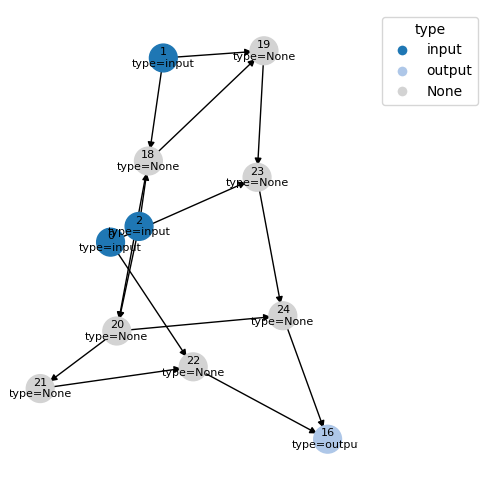

Permutation 0


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [16], 'errors': [], 'warnings': []}
Permutation 1


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [16], 'errors': [], 'warnings': []}


In [15]:
print(f"Base circuit design")
topology_plot_with_attrs(topology_networkx, seed = 1459)

for idx, topology_permutation in enumerate(permuted_graphs):
    print(f"Permutation {idx}")
    #small_topology_plot(topology_permutation) 
    plot_circuit_layered(topology_permutation, show_in_notebook=True, notebook_width = 500, save = False) 
    result = validate_dag(topology_permutation, 1, raise_on_error=True, plot_on_error=True)
    print(result)


In [16]:
#selected_graph = 3  #for 0x17
#permutation_index = 3 #for 0x17
#permutation_index = 0 #for 0x6D

In [17]:
for nodes in topology_networkx.nodes(data = True):
    print(nodes)

(0, {'type': 'input'})
(1, {'type': 'input'})
(2, {'type': 'input'})
(16, {'type': 'output'})
(18, {})
(19, {})
(20, {})
(21, {})
(22, {})
(23, {})
(24, {})


## Import experimental data

In [18]:
input_signals_list_small_molecules, input_names, _ , _ = load_input_data("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/input_data_3_inputs_POSTECH.json")
for row in input_signals_list_small_molecules:
    print(row)

{0: 0.0278, 1: 0.0022, 2: 0.0042}
{0: 0.0278, 1: 0.0022, 2: 2.0082}
{0: 0.0278, 1: 5.0543, 2: 0.0042}
{0: 0.0278, 1: 5.0543, 2: 2.0082}
{0: 3.9239, 1: 0.0022, 2: 0.0042}
{0: 3.9239, 1: 0.0022, 2: 2.0082}
{0: 3.9239, 1: 5.0543, 2: 0.0042}
{0: 3.9239, 1: 5.0543, 2: 2.0082}


In [19]:
input_signals_list_binary = binary_truth_table(len(input_signals_list_small_molecules[0]))
for row in input_signals_list_binary:
    print(row)

{0: 0, 1: 0, 2: 0}
{0: 0, 1: 0, 2: 1}
{0: 0, 1: 1, 2: 0}
{0: 0, 1: 1, 2: 1}
{0: 1, 1: 0, 2: 0}
{0: 1, 1: 0, 2: 1}
{0: 1, 1: 1, 2: 0}
{0: 1, 1: 1, 2: 1}


In [20]:
'''
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    

input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   
'''

# Load the part response experimental data
with open("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/response_data_POSTECH.json") as f:
    repressor_data = json.load(f)

# Create DataFrame
postech_v1_hill_function_parameters = pd.DataFrame(repressor_data)

postech_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load cell growth experimental data
file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/growth_data_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

# show up to 10 decimal places; adjust as you like
pd.set_option("display.float_format", "{:.10f}".format)

postech_v1_hill_function_parameters


,Repressor,RBS,ymaxa,ymina,Ka,n,Toxicity (RPU)
0,AmeR,F1,3.8350000000,1.0600000000,0.1220000000,1.3060000000,-
1,AmtR,A1,5.0360000000,0.0910000000,0.0220000000,1.3080000000,-
2,BetI,E1,3.0650000000,0.0000000000,0.3630000000,1.8330000000,-
3,BM3R1,B1,0.5430000000,0.0020000000,0.0510000000,2.0420000000,-
4,BM3R1,B2,0.8220000000,0.0000000000,0.2850000000,1.6850000000,-
5,BM3R1,B3,0.7040000000,0.0000000000,0.2610000000,1.7680000000,-
6,HlyIIR,H1,2.4620000000,0.0570000000,0.0000000000,2.5960000000,4.0652500000
7,IcaRA,I1,3.5580000000,0.0000000000,0.1860000000,1.0850000000,0.4709400000
8,LitR,L1,4.2960000000,0.0740000000,0.0000000000,1.6960000000,-
9,LmrA,N1,2.1520000000,0.1830000000,0.0000000000,2.0950000000,-


In [21]:
gate_toxicity_df

,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [22]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

Gate count: 7
Info: {'num_nodes': 11, 'num_inputs': 3, 'num_outputs': 1, 'max_removal': 0, 'best_pattern_key': None}


In [23]:
DATA_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data")  
                 
file_path = DATA_DIR / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(postech_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

Found: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/gate_permutations/valid_permutations_7_gates.h5
Loading valid gate permutations
Total valid permutations: 72999360
Example permutation: (0, 1, 2, 3, 6, 7, 8)


#### Set sample size

In [24]:
num_samples = round(len(valid_permutations)*percentage) 
subsample_size = num_samples

#### Adquire trainning data (multiple cores)

In [25]:
Gi = permuted_graphs[permutation_index]
list(Gi.nodes(data = True))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (16, {'type': 'output'}),
 (18, {}),
 (19, {}),
 (20, {}),
 (21, {}),
 (22, {}),
 (23, {}),
 (24, {})]

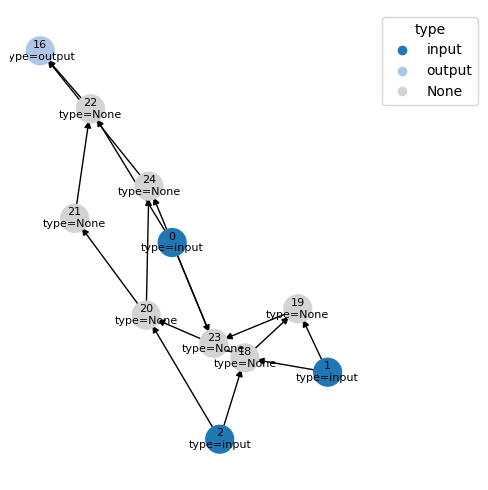

In [26]:
topology_plot_with_attrs(Gi)

In [27]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (16, {'type': 'output'}),
 (18, {}),
 (19, {}),
 (20, {}),
 (21, {}),
 (22, {}),
 (23, {}),
 (24, {})]

In [28]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
adj_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

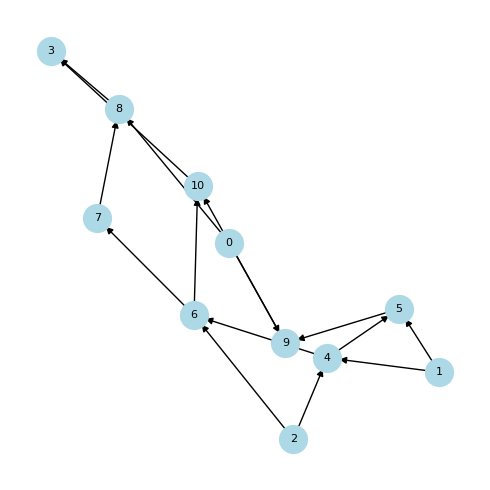

In [29]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)
topology_plot_with_attrs(G)

In [30]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

[4, 5, 6, 7, 8, 9, 10]

In [31]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

In [32]:
# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=valid_permutations,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    num_samples=num_samples,           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file,     # Save every solutions_per_file solutions
    num_cores = CPUs_alloc
    )

Utilizing all 80 cores for parallel processing
Solutions per file: 250,000
Expected number of files: 15
Selecting 3,649,968 random solutions from 72,999,360 valid permutations
Processing 3650 batches using 80 cores


Processing batches:   7%| | 249/3650 [02:50<1:49:33,  1.93s/batch, Solutions=249,000/3,649,968, Elapsed=3.1min, Remaining=42.9min, Solutio


Saving file 0 with 250,000 solutions...


Processing batches:   7%| | 258/3650 [02:57<1:14:04,  1.31s/batch, Solutions=259,000/3,649,968, Elapsed=3.3min, Remaining=42.7min, Solutio

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_0.pkl


Processing batches:  14%|▏| 499/3650 [05:00<1:34:48,  1.81s/batch, Solutions=499,000/3,649,968, Elapsed=5.3min, Remaining=33.6min, Solutio


Saving file 1 with 250,000 solutions...


Processing batches:  14%|▏| 504/3650 [05:11<3:22:41,  3.87s/batch, Solutions=505,000/3,649,968, Elapsed=5.5min, Remaining=34.2min, Solutio

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_1.pkl


Processing batches:  21%|▏| 749/3650 [07:11<58:41,  1.21s/batch, Solutions=749,000/3,649,968, Elapsed=7.5min, Remaining=29.0min, Solutions


Saving file 2 with 250,000 solutions...


Processing batches:  21%|▏| 759/3650 [07:23<3:17:51,  4.11s/batch, Solutions=760,000/3,649,968, Elapsed=7.7min, Remaining=29.3min, Solutio

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_2.pkl


Processing batches:  27%|▎| 999/3650 [09:26<26:04,  1.69batch/s, Solutions=999,000/3,649,968, Elapsed=9.7min, Remaining=25.9min, Solutions


Saving file 3 with 250,000 solutions...


Processing batches:  27%|▎| 999/3650 [09:37<26:04,  1.69batch/s, Solutions=1,000,000/3,649,968, Elapsed=9.9min, Remaining=26.3min, Solutio

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_3.pkl


Processing batches:  34%|▎| 1249/3650 [11:45<06:19,  6.33batch/s, Solutions=1,249,000/3,649,968, Elapsed=12.1min, Remaining=23.2min, Solut


Saving file 4 with 250,000 solutions...


Processing batches:  34%|▎| 1250/3650 [11:56<1:39:02,  2.48s/batch, Solutions=1,250,000/3,649,968, Elapsed=12.2min, Remaining=23.5min, Sol

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_4.pkl


Processing batches:  41%|▍| 1499/3650 [14:08<08:09,  4.40batch/s, Solutions=1,499,000/3,649,968, Elapsed=14.4min, Remaining=20.7min, Solut


Saving file 5 with 250,000 solutions...


Processing batches:  41%|▍| 1501/3650 [14:17<1:00:53,  1.70s/batch, Solutions=1,502,000/3,649,968, Elapsed=14.6min, Remaining=20.9min, Sol

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_5.pkl


Processing batches:  48%|▍| 1749/3650 [16:26<22:19,  1.42batch/s, Solutions=1,749,000/3,649,968, Elapsed=16.7min, Remaining=18.2min, Solut


Saving file 6 with 250,000 solutions...


Processing batches:  48%|▍| 1753/3650 [16:39<1:00:24,  1.91s/batch, Solutions=1,753,000/3,649,968, Elapsed=17.0min, Remaining=18.4min, Sol

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_6.pkl


Processing batches:  55%|▌| 1999/3650 [18:42<54:00,  1.96s/batch, Solutions=1,999,000/3,649,968, Elapsed=19.0min, Remaining=15.7min, Solut


Saving file 7 with 250,000 solutions...


Processing batches:  55%|▌| 2010/3650 [18:53<1:29:18,  3.27s/batch, Solutions=2,011,000/3,649,968, Elapsed=19.2min, Remaining=15.7min, Sol

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_7.pkl


Processing batches:  62%|▌| 2249/3650 [20:52<13:46,  1.69batch/s, Solutions=2,249,000/3,649,968, Elapsed=21.2min, Remaining=13.2min, Solut


Saving file 8 with 250,000 solutions...


Processing batches:  62%|▌| 2259/3650 [21:03<1:20:15,  3.46s/batch, Solutions=2,260,000/3,649,968, Elapsed=21.4min, Remaining=13.1min, Sol

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_8.pkl


Processing batches:  68%|▋| 2499/3650 [23:15<16:46,  1.14batch/s, Solutions=2,499,000/3,649,968, Elapsed=23.6min, Remaining=10.9min, Solut


Saving file 9 with 250,000 solutions...


Processing batches:  69%|▋| 2512/3650 [23:27<41:02,  2.16s/batch, Solutions=2,513,000/3,649,968, Elapsed=23.8min, Remaining=10.8min, Solut

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_9.pkl


Processing batches:  75%|▊| 2749/3650 [25:30<01:54,  7.85batch/s, Solutions=2,749,000/3,649,968, Elapsed=25.8min, Remaining=8.5min, Soluti


Saving file 10 with 250,000 solutions...


Processing batches:  76%|▊| 2763/3650 [25:41<19:58,  1.35s/batch, Solutions=2,764,000/3,649,968, Elapsed=26.0min, Remaining=8.3min, Soluti

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_10.pkl


Processing batches:  82%|▊| 2999/3650 [27:56<04:47,  2.27batch/s, Solutions=2,999,000/3,649,968, Elapsed=28.2min, Remaining=6.1min, Soluti


Saving file 11 with 250,000 solutions...


Processing batches:  82%|▊| 3001/3650 [28:04<17:07,  1.58s/batch, Solutions=3,001,000/3,649,968, Elapsed=28.4min, Remaining=6.1min, Soluti

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_11.pkl


Processing batches:  89%|▉| 3249/3650 [30:11<08:28,  1.27s/batch, Solutions=3,249,000/3,649,968, Elapsed=30.5min, Remaining=3.8min, Soluti


Saving file 12 with 250,000 solutions...


Processing batches:  89%|▉| 3255/3650 [30:25<10:33,  1.60s/batch, Solutions=3,255,000/3,649,968, Elapsed=30.7min, Remaining=3.7min, Soluti

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_12.pkl


Processing batches:  96%|▉| 3499/3650 [32:26<05:21,  2.13s/batch, Solutions=3,499,000/3,649,968, Elapsed=32.7min, Remaining=1.4min, Soluti


Saving file 13 with 250,000 solutions...


Processing batches:  96%|▉| 3511/3650 [32:37<04:13,  1.82s/batch, Solutions=3,512,000/3,649,968, Elapsed=32.9min, Remaining=1.3min, Soluti

Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_13.pkl


Processing batches: 100%|█| 3650/3650 [33:31<00:00,  1.81batch/s, Solutions=3,649,968/3,649,968, Elapsed=33.8min, Remaining=0.0min, Soluti



Saving final file with 149,968 solutions...
Successfully saved 149,968 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/training_data_0x6D_design_0_permutation_0/results_large_batch_14.pkl

Processing completed!
Total solutions processed: 3,649,968
Total time: 33.9 minutes
Average processing speed: 1793.4 solutions/second
Total files created: 15


In [33]:
run_timing_analysis = False

Timing plot with total times

In [34]:
if run_timing_analysis:
    import time, random
    from pathlib import Path
    import matplotlib.pyplot as plt

    core_grid = [10, 20, 40, 80, 100, 120]  

    # Fix the workload so runs are comparable
    rng = random.Random(123)
    random_indices = rng.sample(range(len(valid_permutations)), num_samples)
    fixed_perms = [valid_permutations[i] for i in random_indices]

    times = []
    for n in core_grid:
        print(f"\n=== Testing num_cores={n} ===")
        t0 = time.perf_counter()
        
        # Use a unique subdir so runs don't interfere
        outdir_n = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/mp_time_data_v1/{circuit_name}_design_{selected_graph}_permutation_{permutation_index}_{n}_workers"

        results_summary = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=fixed_perms,                   # <- fixed workload
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=outdir_n,                              # <- unique output
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n
        )
        times.append(time.perf_counter() - t0)

    # Plot
    plt.figure()
    plt.plot(core_grid, times, "-o")
    plt.xlabel("num_cores (processes)")
    plt.ylabel("Runtime (s)")
    plt.title("Runtime vs num_cores")
    plt.grid(True)
    plt.show()

Timing plot with time versus solutions

In [35]:
if run_timing_analysis:
    import time, random
    from pathlib import Path
    import matplotlib.pyplot as plt

    core_grid = [20, 40, 80]  # ≤ CPUs_alloc

    # Fix workload for fair comparison
    rng = random.Random(123)
    random_indices = rng.sample(range(len(valid_permutations)), num_samples)
    fixed_perms = [valid_permutations[i] for i in random_indices]

    run_summaries = []

    for n in core_grid:
        print(f"\n=== Testing num_cores={n} ===")
        outdir_n = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/mp_time_data_v2/{circuit_name}_design_{selected_graph}_permutation_{permutation_index}_{n}_workers"

        summary = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=fixed_perms,                   # fixed workload
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=outdir_n,                              # unique output
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n
        )
        run_summaries.append((n, summary))

    # Plot: x = time, y = number of solutions 
    plt.figure()
    for n, summary in run_summaries:
        prog = summary['progress']  # list of (elapsed_s, processed_solutions)
        xs = [t/60.0 for (t, _) in prog]   # minutes on x-axis 
        ys = [s for (_, s) in prog]
        plt.plot(xs, ys, "-o", label=f"{n} cores")

        # mark final point
        plt.scatter(xs[-1], ys[-1])

    plt.xlabel("Time (minutes)")  
    plt.ylabel("Number of solutions processed")
    plt.title("Solutions vs Time for different num_cores")
    plt.grid(True)
    plt.legend(title="Workers")
    plt.tight_layout()
    plt.show()

### Load training data

In [36]:
# Load all results
(permutations, toxicity_scores, circuit_scores, roadblocking_flags) = load_circuit_results(Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations.shape}")
    print(f"Toxicity scores shape: {toxicity_scores.shape}")
    print(f"Circuit scores shape: {circuit_scores.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags.shape}")

Found 15 batch files to load


Loading results:  13%|█████████████▊                                                                                          | 2/15 [00:16<01:46,  8.17s/it]


Processed 500,000 solutions so far...


Loading results:  27%|███████████████████████████▋                                                                            | 4/15 [00:34<01:36,  8.75s/it]


Processed 1,000,000 solutions so far...


Loading results:  40%|█████████████████████████████████████████▌                                                              | 6/15 [00:49<01:11,  7.98s/it]


Processed 1,500,000 solutions so far...


Loading results:  53%|███████████████████████████████████████████████████████▍                                                | 8/15 [01:03<00:52,  7.45s/it]


Processed 2,000,000 solutions so far...


Loading results:  67%|████████████████████████████████████████████████████████████████████▋                                  | 10/15 [01:17<00:36,  7.24s/it]


Processed 2,500,000 solutions so far...


Loading results:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 12/15 [01:32<00:22,  7.44s/it]


Processed 3,000,000 solutions so far...


Loading results:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 14/15 [01:47<00:07,  7.43s/it]


Processed 3,500,000 solutions so far...


Loading results: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:52<00:00,  7.51s/it]



Loading completed:
Total results loaded: 3,649,968
Unique permutations: 3,649,968
Average circuit score: 0.509
Average toxicity score: 0.481
Roadblocking percentage: 90.9%

Data shape summary:
Permutations shape: (3649968, 7)
Toxicity scores shape: (3649968,)
Circuit scores shape: (3649968,)
Roadblocking flags shape: (3649968,)


### List top biological designs in the training data

In [37]:
no_roadblock_mask_training_data = ~roadblocking_flags
permutations_no_roadblocking_training_data = permutations[no_roadblock_mask_training_data]
circuit_scores_no_roadblocking_training_data = circuit_scores[no_roadblock_mask_training_data]
toxicity_scores_no_roadblocking_training_data = toxicity_scores[no_roadblock_mask_training_data]
roadblocking_flags_no_roadblocking_training_data = roadblocking_flags[no_roadblock_mask_training_data]

toxicity_filter_training_data = toxicity_scores_no_roadblocking_training_data >= 0.75
permutations_no_roadblocking_toxicity_filtered_training_data = permutations_no_roadblocking_training_data[toxicity_filter_training_data]
circuit_scores_no_roadblocking_toxicity_filtered_training_data = circuit_scores_no_roadblocking_training_data[toxicity_filter_training_data]
toxicity_scores_no_roadblocking_toxicity_filtered_training_data = toxicity_scores_no_roadblocking_training_data[toxicity_filter_training_data]
roadblocking_flags_no_roadblocking_toxicity_filtered_training_data = roadblocking_flags_no_roadblocking_training_data[toxicity_filter_training_data]

#print(circuit_scores_no_roadblocking_toxicity_filtered_training_data)

In [38]:
print(len(circuit_scores_no_roadblocking_toxicity_filtered_training_data))

19


In [39]:
# Find top N circuit scores
N_training_data = 1  # Change this number to get more or fewer top scores
top_n_indices_training_data = np.argsort(circuit_scores_no_roadblocking_toxicity_filtered_training_data)[-N_training_data:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N_training_data} Circuit Scores (no roadblocking, toxicity >= 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details_training_data = {}

for rank, idx in enumerate(top_n_indices_training_data, 1):
    
    corresponding_index_training_data = idx

    best_permutation_training_data = permutations_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    roadblock_flag_training_data = roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    print(f"{rank:4d} | {circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx]:12.4f} | "
          f"{toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx]:13.4f} | "
          f"{str(roadblock_flag_training_data):11} | {best_permutation_training_data}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details_training_data = {
            'circuit_score': circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'toxicity_score': toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'roadblocking': roadblock_flag_training_data,
            'permutation': best_permutation_training_data
        }

# Print detailed information for highest scoring design after the table
print("\n" + "-"*100)
print("Detailed information for highest scoring design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details_training_data['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details_training_data['toxicity_score']}")
print(f"Roadblocking: {highest_score_details_training_data['roadblocking']}")
print(f"Permutation: {highest_score_details_training_data['permutation']}")


Top 1 Circuit Scores (no roadblocking, toxicity >= 0.75):
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |       0.9979 |        0.7515 | False       | [ 1  0 10  2  5  9 15]

----------------------------------------------------------------------------------------------------
Detailed information for highest scoring design:
----------------------------------------------------------------------------------------------------
Highest actual circuit score: 0.9979069769397615
Corresponding actual toxicity score: 0.7514943219584758
Roadblocking: False
Permutation: [ 1  0 10  2  5  9 15]


In [40]:
rows = []
for rank, idx in enumerate(top_n_indices_training_data, 1):
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Toxicity Score"  : toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Roadblocking"    : roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[idx],
        "Permutation"     : permutations_no_roadblocking_toxicity_filtered_training_data[idx],
    })


csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_in_trainning_data_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")


 Saved 1 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/scores_top_designs_in_trainning_data_0x6D_0_0.csv


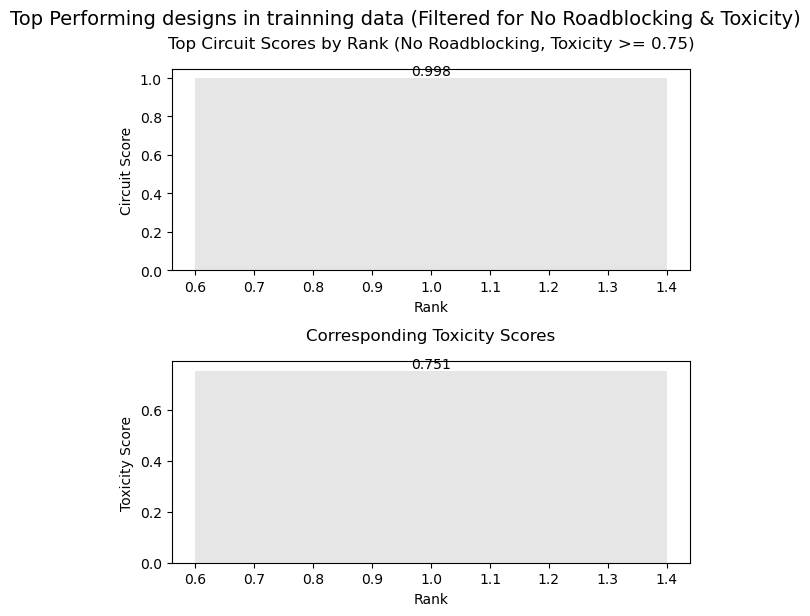


Statistics Summary:
--------------------------------------------------
Circuit Scores - Mean: 0.998, Std: 0.000
Toxicity Scores - Mean: 0.751, Std: 0.000


In [41]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N_training_data + 1))
circuit_scores_training_data_top = circuit_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]
toxicity_scores_training_data_top = toxicity_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores_training_data_top, color='gainsboro', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank (No Roadblocking, Toxicity >= 0.75)', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
#ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores_training_data_top, color='gainsboro', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
#ax2.grid(False, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Top Performing designs in trainning data (Filtered for No Roadblocking & Toxicity)', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis_filtered.png', dpi=300, bbox_inches='tight')

plt.show()

# Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores_training_data_top):.3f}, Std: {np.std(circuit_scores_training_data_top):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores_training_data_top):.3f}, Std: {np.std(toxicity_scores_training_data_top):.3f}")

## Define model

### Prepare data for training 

In [42]:
X_all = np.array(permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
y_all = np.column_stack((toxicity_scores, circuit_scores)).astype(np.float32)  # Convert to a NumPy array
roadblocking_flags = np.array(roadblocking_flags)  # Convert all_roadblocking_flags to a NumPy array

num_classes = len(postech_v1_hill_function_parameters)
num_biological_parts = gate_count

In [43]:
# Data Preparation and Filter by circuit score > 0and roadblocking
#filter_mask = (y_all[:, 1] > 0) & (roadblocking_flags == False)

# Data Preparation and Filter by circuit score > n
filter_mask = y_all[:, 1] >= 0

X_all_filtered = X_all[filter_mask]
y_all_circuit_scores_filtered = y_all[filter_mask, 1]
y_all_toxicity_scores_filtered = y_all[filter_mask, 0]

print("Data " ,len(X_all_filtered))

#Subsample randomly and maintain order of data

# Check if we have enough samples and generate indices for subsampling
if len(X_all_filtered) >= subsample_size:
    # Get random indices and sort them to maintain order
    subsample_indices = np.sort(np.random.choice(len(X_all_filtered), subsample_size, replace=False))
else:
    print(f"Warning: Requested {subsample_size} samples, but only {len(X_all_filtered)} are available after filtering.")
    subsample_indices = np.arange(len(X_all_filtered))  # Simply use all indices in order
    subsample_size = len(X_all_filtered)  # Adjust subsample_size to the available data
    
# Subsample the data
X_all_filtered_subsampled = X_all_filtered[subsample_indices]
y_all_circuit_scores_filtered_subsampled = y_all_circuit_scores_filtered[subsample_indices]
y_all_toxicity_scores_filtered_subsampled = y_all_toxicity_scores_filtered[subsample_indices]

# Convert X to PyTorch tensor and perform one-hot encoding
X_all_filtered_subsampled_tensor = th.from_numpy(X_all_filtered_subsampled).long()
X_all_filtered_subsampled_tensor_one_hot = F.one_hot(X_all_filtered_subsampled_tensor, num_classes=num_classes).float()

# Convert y to PyTorch tensors
y_all_circuit_scores_filtered_subsampled_tensor = th.from_numpy(y_all_circuit_scores_filtered_subsampled).float().unsqueeze(1)
y_all_toxicity_scores_filtered_subsampled_tensor = th.from_numpy(y_all_toxicity_scores_filtered_subsampled).float().unsqueeze(1)

# Split the data into train / val / test
train_ratio = 0.80
val_ratio   = 0.10  # test will be the remainder 

num_samples = X_all_filtered_subsampled_tensor_one_hot.shape[0]
num_train = int(train_ratio * num_samples)
num_val   = int(val_ratio * num_samples)
num_test  = num_samples - num_train - num_val  # ensure all samples are used

perm = np.random.permutation(num_samples)
train_idx = perm[:num_train]
val_idx   = perm[num_train:num_train + num_val]
test_idx  = perm[num_train + num_val:]

# Build splits
X_training_set = X_all_filtered_subsampled_tensor_one_hot[train_idx]
y_circuit_scores_training_set = y_all_circuit_scores_filtered_subsampled_tensor[train_idx]
y_toxicity_scores_training_set = y_all_toxicity_scores_filtered_subsampled_tensor[train_idx]

X_val_set = X_all_filtered_subsampled_tensor_one_hot[val_idx]
y_circuit_scores_val_set = y_all_circuit_scores_filtered_subsampled_tensor[val_idx]
y_toxicity_scores_val_set = y_all_toxicity_scores_filtered_subsampled_tensor[val_idx]

X_test_set = X_all_filtered_subsampled_tensor_one_hot[test_idx]
y_circuit_scores_test_set = y_all_circuit_scores_filtered_subsampled_tensor[test_idx]
y_toxicity_scores_test_set = y_all_toxicity_scores_filtered_subsampled_tensor[test_idx]

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

# Device Setup
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Shuffle training data
shuffle_indices = th.randperm(X_training_set.size(0))
X_training_set_shuffled = X_training_set[shuffle_indices].to(device)
y_circuit_scores_training_set_shuffled = y_circuit_scores_training_set[shuffle_indices].to(device)
y_toxicity_scores_training_set_shuffled = y_toxicity_scores_training_set[shuffle_indices].to(device)

# Move val/test to device
X_val_set = X_val_set.to(device)
y_circuit_scores_val_set = y_circuit_scores_val_set.to(device)
y_toxicity_scores_val_set = y_toxicity_scores_val_set.to(device)

X_test_set = X_test_set.to(device)
y_circuit_scores_test_set = y_circuit_scores_test_set.to(device)
y_toxicity_scores_test_set = y_toxicity_scores_test_set.to(device)

Data  3649968
Split sizes -> train: 2919974, val: 364996, test: 364998
Using device: cuda


### Trainning

In [44]:
import torch.multiprocessing as mp

Training Progress:  20%|▏| 5/25 [07:08<28:32, 85.63s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 5. Best loss = 0.000141


Training Progress:  20%|▏| 5/25 [07:15<29:02, 87.11s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 5. Best loss = 0.000147


Training Progress:  24%|▏| 6/25 [07:35<24:01, 75.87s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 6. Best loss = 0.000173


Training Progress:  20%|▏| 5/25 [07:29<29:56, 89.82s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 5. Best loss = 0.000131


Training Progress:  20%|▏| 5/25 [07:31<30:05, 90.29s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 5. Best loss = 0.000144


Training Progress:  20%|▏| 5/25 [07:46<31:06, 93.34s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 5. Best loss = 0.000130


Training Progress:  24%|▏| 6/25 [08:12<25:58, 82.04s/it, Train=0.0002, Eval=0.0


[EarlyStop] Stopping at epoch 6. Best loss = 0.000301


Training Progress:  28%|▎| 7/25 [08:53<22:52, 76.28s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 7. Best loss = 0.000098


Training Progress:  28%|▎| 7/25 [09:00<23:08, 77.14s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 7. Best loss = 0.000093


Training Progress:  32%|▎| 8/25 [09:50<20:55, 73.87s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 8. Best loss = 0.000101


Training Progress:  32%|▎| 8/25 [10:03<21:22, 75.43s/it, Train=0.0003, Eval=0.0


[EarlyStop] Stopping at epoch 8. Best loss = 0.000322


Training Progress:  36%|▎| 9/25 [11:00<19:34, 73.39s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 9. Best loss = 0.000081


Training Progress:  40%|▍| 10/25 [11:08<16:42, 66.80s/it, Train=0.0003, Eval=0.


[EarlyStop] Stopping at epoch 10. Best loss = 0.000270


Training Progress:  36%|▎| 9/25 [11:18<20:06, 75.43s/it, Train=0.0001, Eval=0.0


[EarlyStop] Stopping at epoch 9. Best loss = 0.000127


Training Progress:  40%|▍| 10/25 [11:52<17:49, 71.27s/it, Train=0.0000, Eval=0.


[EarlyStop] Stopping at epoch 10. Best loss = 0.000050


Training Progress:  44%|▍| 11/25 [12:00<15:17, 65.53s/it, Train=0.0003, Eval=0.


[EarlyStop] Stopping at epoch 11. Best loss = 0.000343


Training Progress:  72%|▋| 18/25 [18:29<07:11, 61.63s/it, Train=0.0052, Eval=0.


[EarlyStop] Stopping at epoch 18. Best loss = 0.008601


Training Progress:  76%|▊| 19/25 [19:35<06:11, 61.86s/it, Train=0.0037, Eval=0.


[EarlyStop] Stopping at epoch 19. Best loss = 0.007779


Training Progress: 100%|█| 25/25 [21:25<00:00, 51.40s/it, Train=0.0550, Eval=0.
Training Progress: 100%|█| 25/25 [21:46<00:00, 52.25s/it, Train=0.0034, Eval=0.
Training Progress: 100%|█| 25/25 [21:47<00:00, 52.31s/it, Train=0.0502, Eval=0.
Training Progress: 100%|█| 25/25 [21:52<00:00, 52.48s/it, Train=0.0641, Eval=0.
Training Progress: 100%|█| 25/25 [22:30<00:00, 54.03s/it, Train=0.0404, Eval=0.
Training Progress: 100%|█| 25/25 [22:25<00:00, 53.81s/it, Train=0.0025, Eval=0.
Training Progress: 100%|█| 25/25 [22:34<00:00, 54.19s/it, Train=0.0045, Eval=0.
Training Progress: 100%|█| 25/25 [22:50<00:00, 54.81s/it, Train=0.0041, Eval=0.
Training Progress: 100%|█| 25/25 [22:45<00:00, 54.62s/it, Train=0.0070, Eval=0.
Training Progress: 100%|█| 25/25 [23:12<00:00, 55.69s/it, Train=0.0067, Eval=0.
Training Progress: 100%|█| 25/25 [23:17<00:00, 55.91s/it, Train=0.0067, Eval=0.
Training Progress: 100%|█| 25/25 [23:18<00:00, 55.93s/it, Train=0.0065, Eval=0.
Training Progress:  96%|▉| 24/25 [23:52<

[EarlyStop] Stopping at epoch 24. Best loss = 0.005234


Training Progress: 100%|█| 25/25 [24:02<00:00, 57.72s/it, Train=0.0040, Eval=0.


Training finished:
 - toxicity_score_L7_W256: device=cuda:1 final_val_or_train=0.000063
   model:  /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/toxicity_score_L7_W256.pt
   losses: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/toxicity_score_L7_W256_losses.pt
 - toxicity_score_L9_W128: device=cuda:0 final_val_or_train=0.000052
   model:  /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/toxicity_score_L9_W128.pt
   losses: /home/gridsan/spalacios/Designing complex biological circuits with deep neural

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:197: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


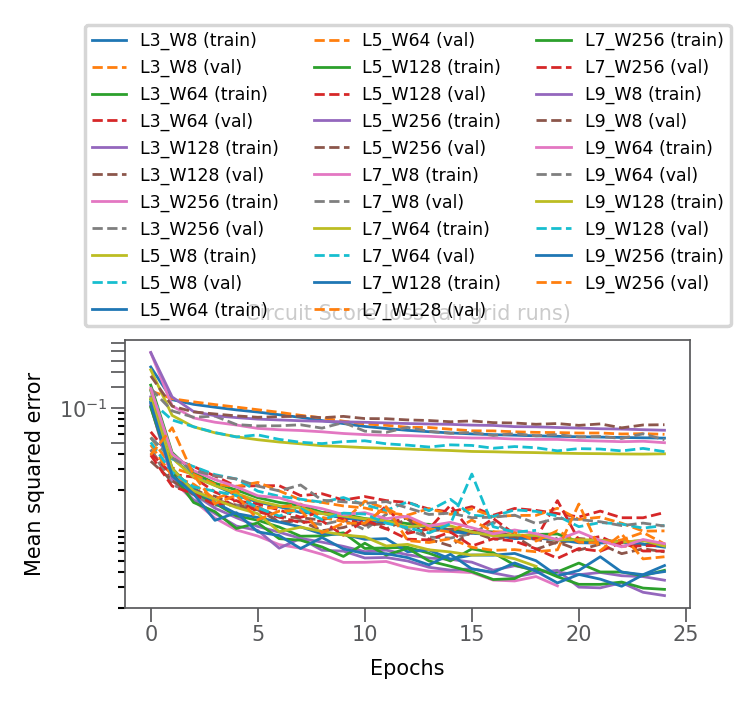

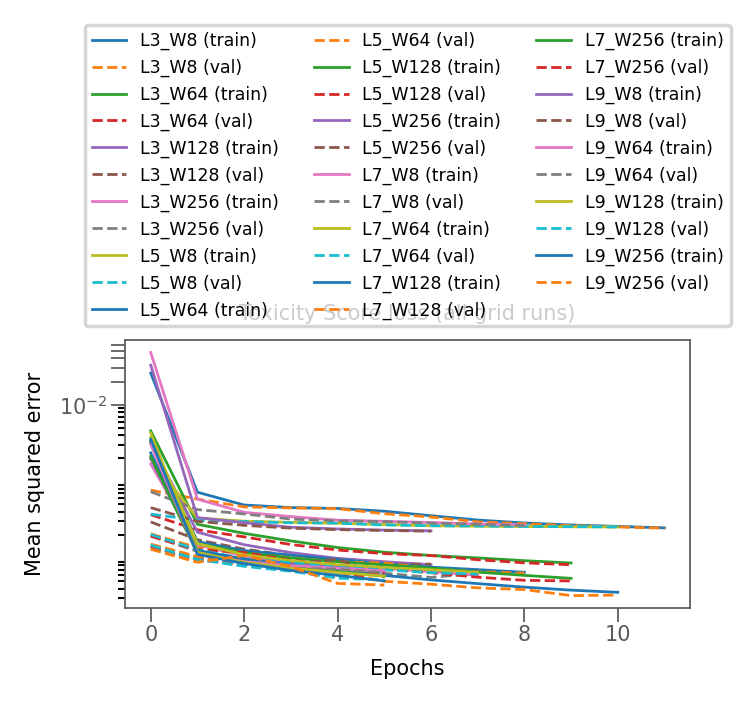

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


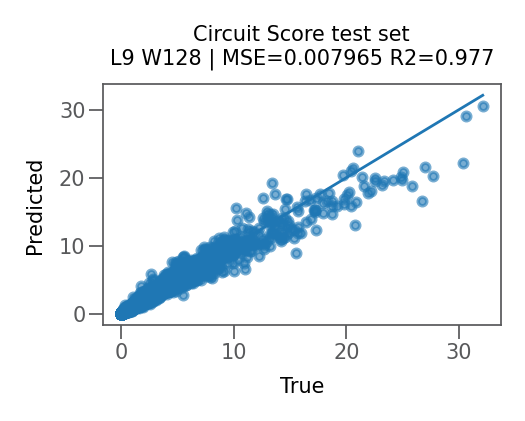

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


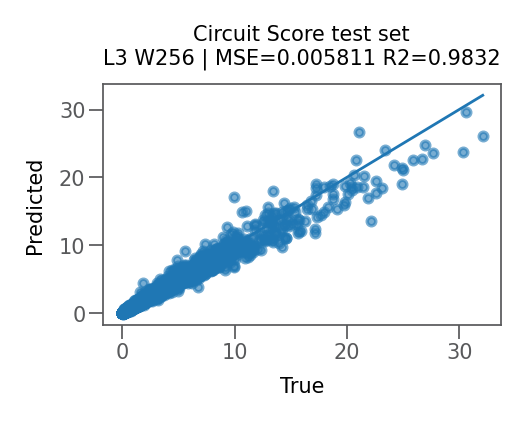

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


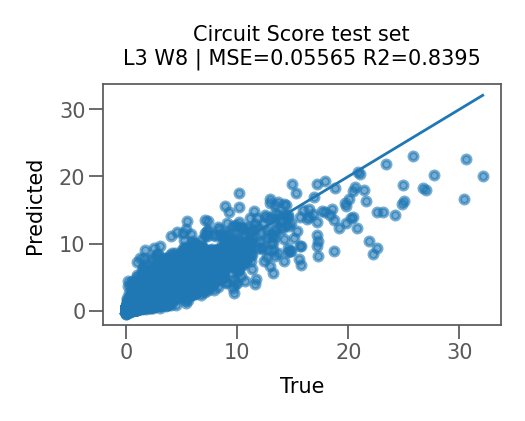

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


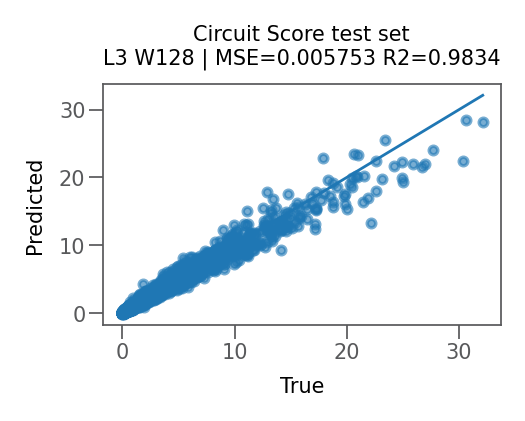

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


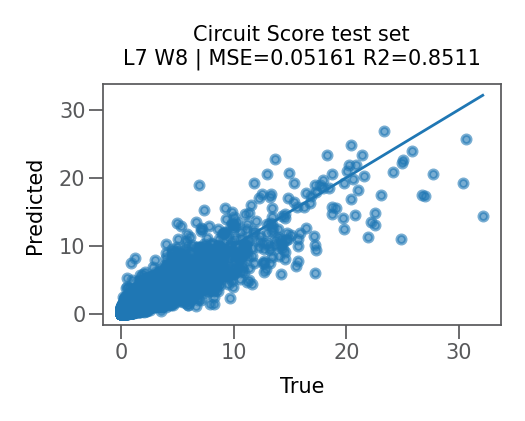

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


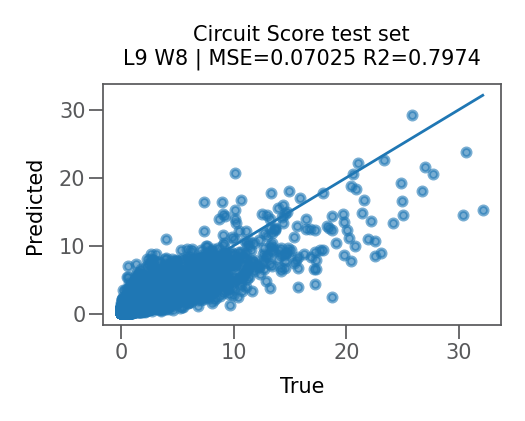

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


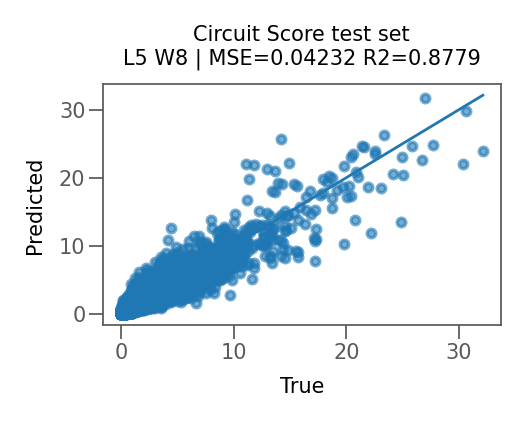

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


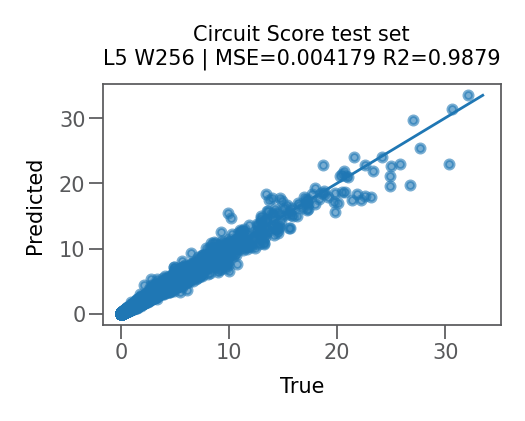

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


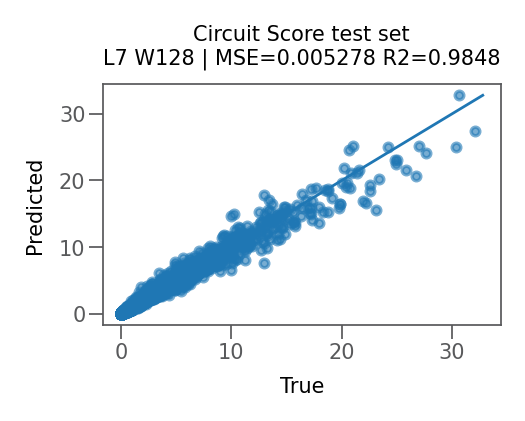

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


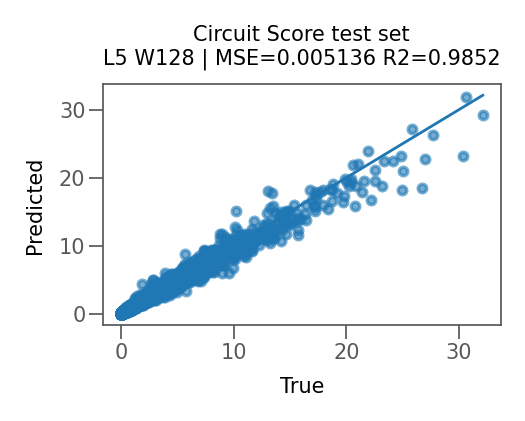

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


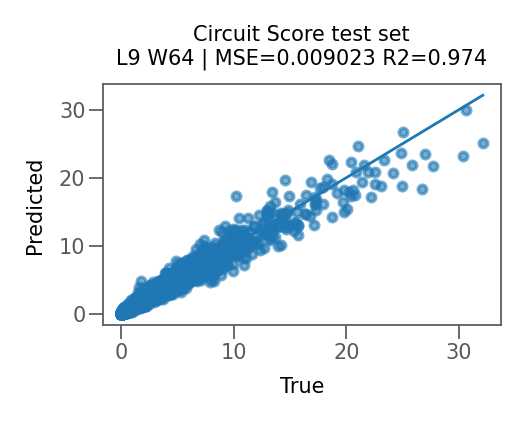

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


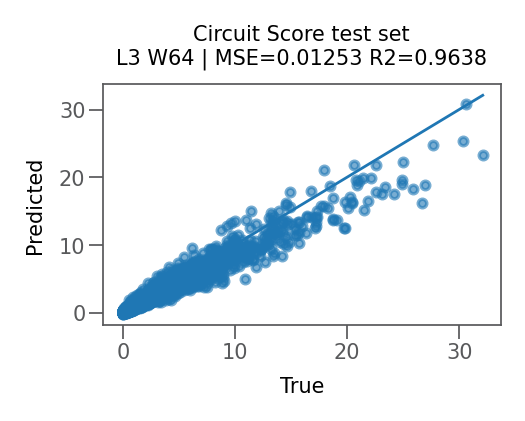

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


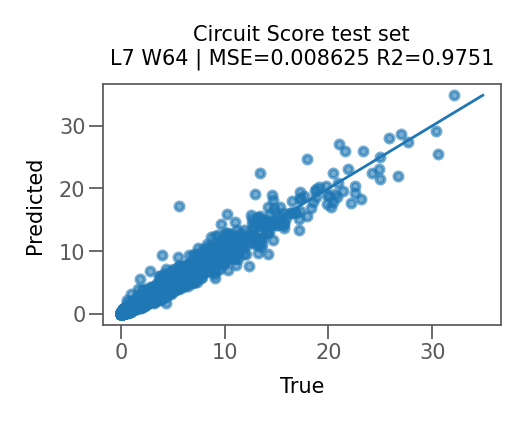

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


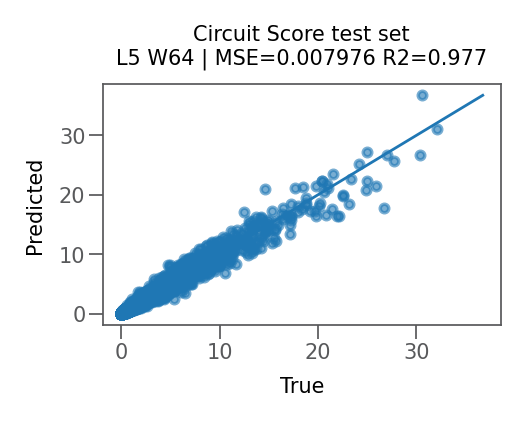

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


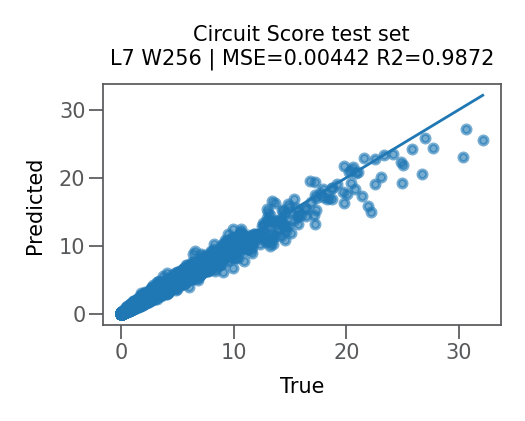

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


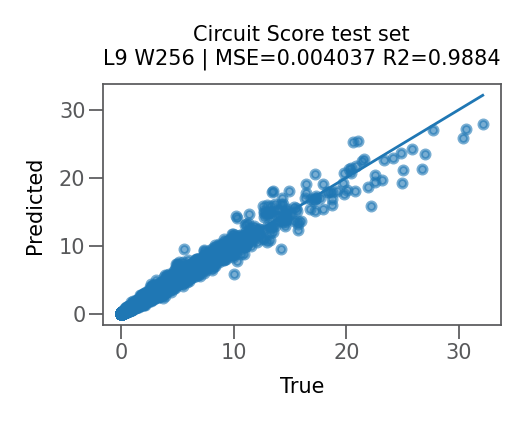

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


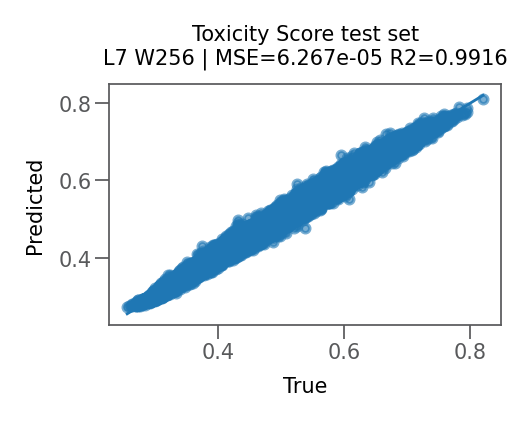

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


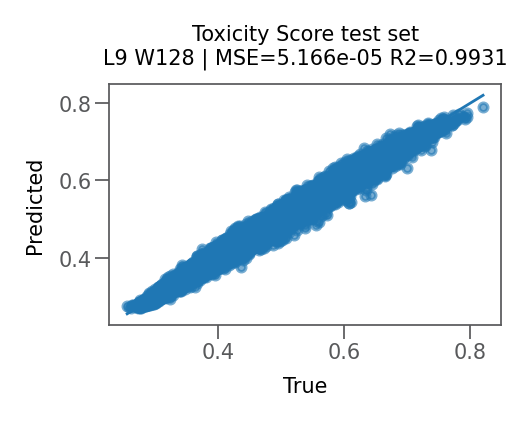

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


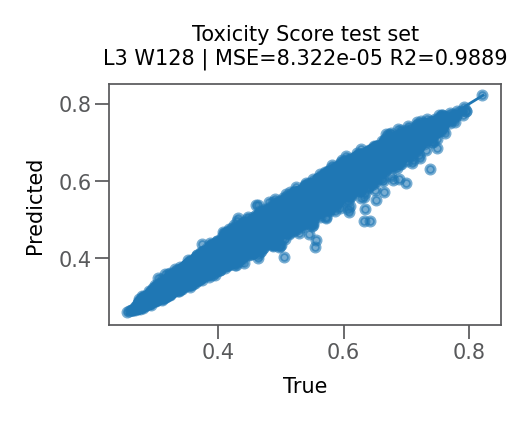

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


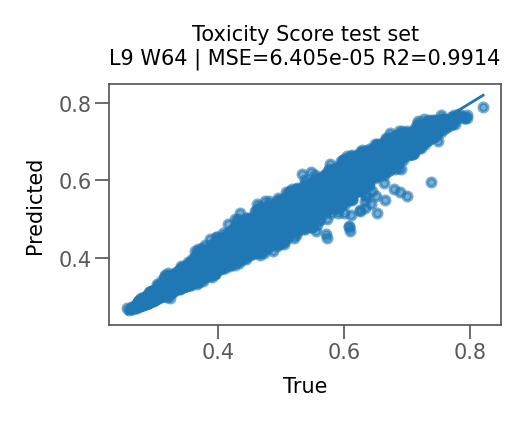

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


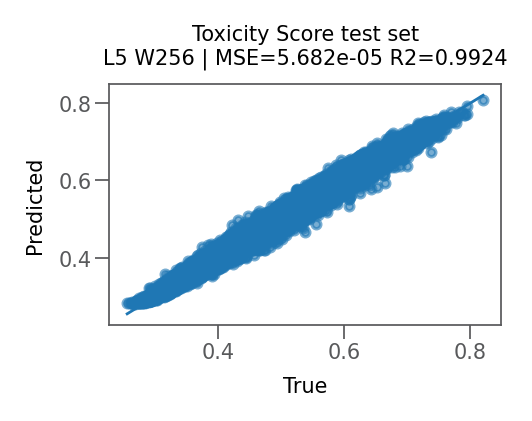

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


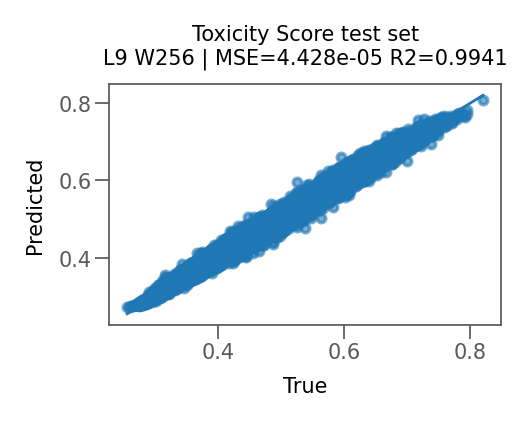

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


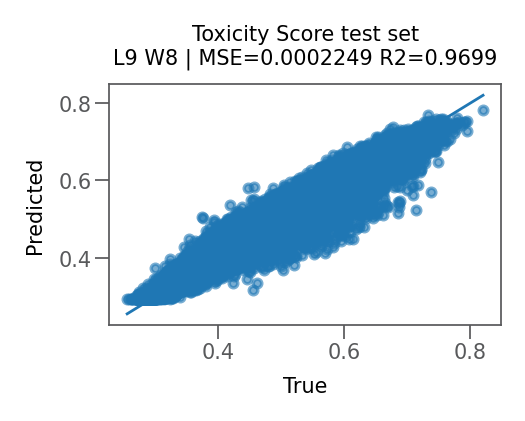

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


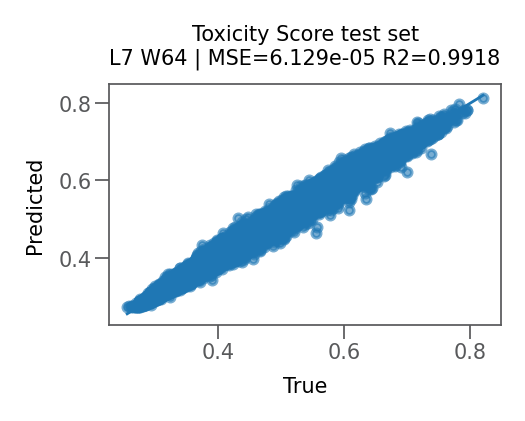

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


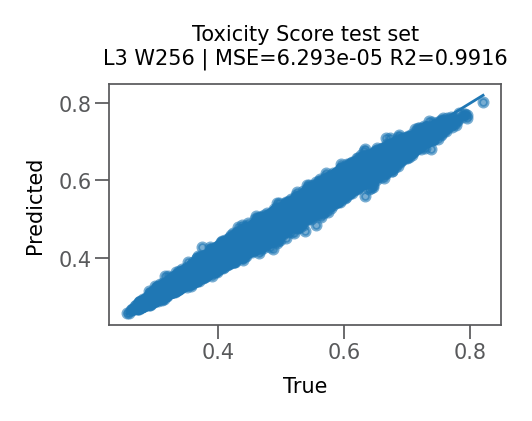

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


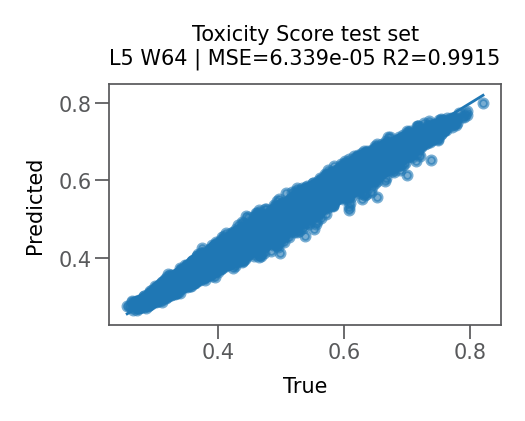

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


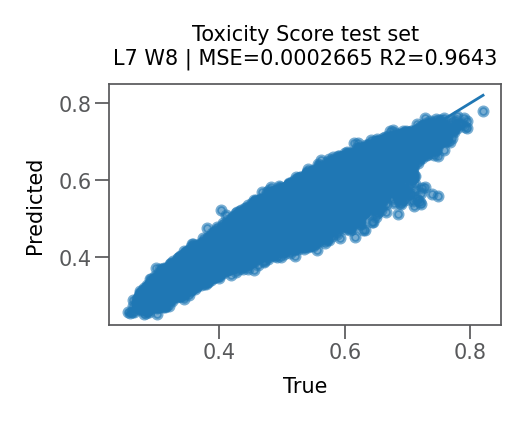

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


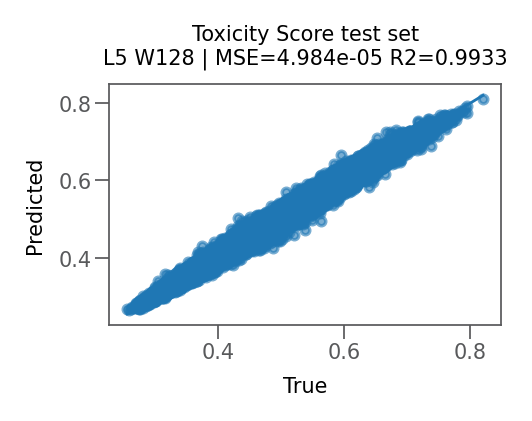

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


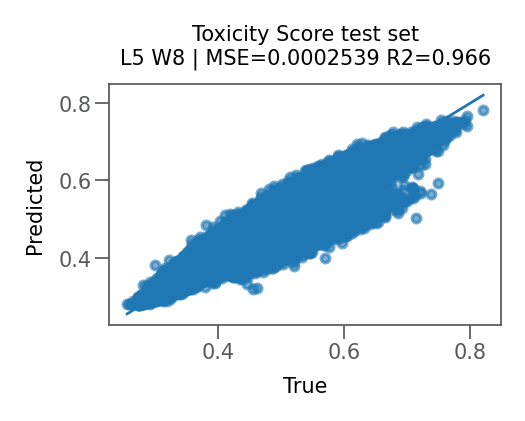

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


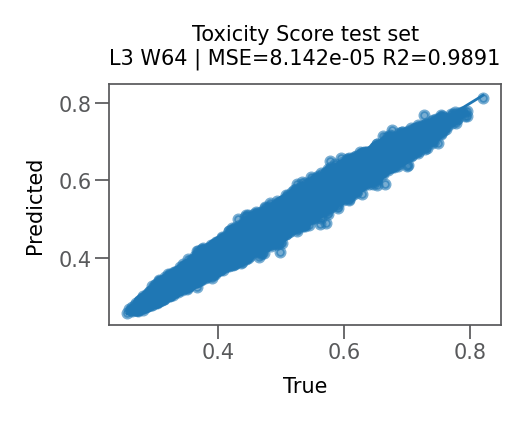

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


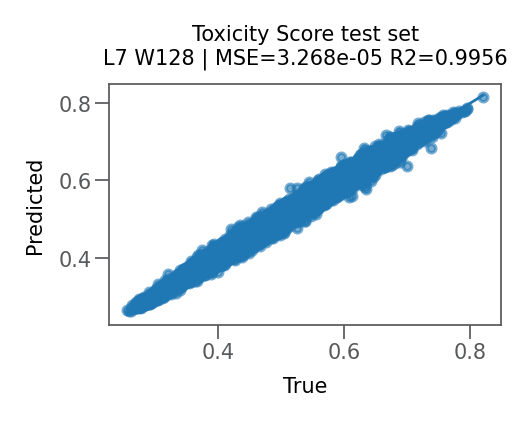

/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = th.tensor(X_test, dtype=th.float32, device=device)
/state/partition1/slurm_tmp/3304751.0.0/ipykernel_3384837/1059930982.py:219: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)


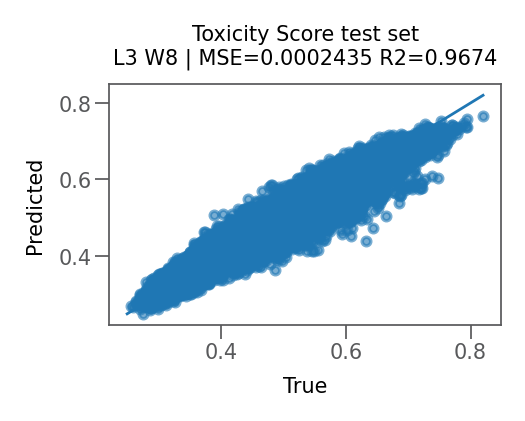


=== GRID SEARCH SUMMARY ===
task             L     W     val_loss     test_mse  test_r2  path
circuit_score    9   256   0.00539933   0.00403711   0.9884  /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/circuit_score_L9_W256.pt
circuit_score    5   256   0.00594623   0.00417861   0.9879  /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/circuit_score_L5_W256.pt
circuit_score    7   256    0.0060336   0.00442014   0.9872  /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig4and5_single_circuits_0x6D/seed_1/optimal_topologies/neural_networks_HPO/seed_1/0x6D_design_0_permutation_0/circuit_score_L7_W256.pt
circuit_sco

In [45]:
# ===================== GRID SEARCH OVER DEPTH & WIDTH =====================
# Trains both tasks, plots all losses, evaluates on test set, prints summary
# Overwriting models/plots is OK; metrics are collected from run_one_job outputs
# ==========================================================================

import itertools
import multiprocessing as mp
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim  # if needed elsewhere
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.metrics import mean_squared_error, r2_score

mp.set_start_method("spawn", force=True)

# -------------------------
# CONFIG
# -------------------------
# epochs per task
num_epochs_circuit_score_model = 25
num_epochs_toxicity_score_model = 25

# I/O + sizes
input_size  = num_biological_parts * num_classes
output_size = 1

# grid to search (edit as desired)
LAYER_GRID = [3, 5, 7, 9]        # depths
WIDTH_GRID = [8, 64, 128, 256]   # widths

# shared training hyperparams
common_kwargs = dict(
    dropout=0.0,
    lr=1e-3,
    batch_size=4096,
    evaluate_validation_set=True,
    early_stop_patience=5,
    early_stop_min_delta=1e-4,  # tweak if you like
)

# -------------------------
# BUILD JOBS
# -------------------------
n_available = th.cuda.device_count()
gpu_ids = list(range(n_available))

def _pick_gpu(i):
    if n_available == 0:
        return None
    return gpu_ids[i % n_available]

jobs = []

# circuit_score jobs
for j, (L, W) in enumerate(itertools.product(LAYER_GRID, WIDTH_GRID)):
    jobs.append(
        TrainJob(
            name=f"circuit_score_L{L}_W{W}",
            gpu_id=_pick_gpu(j),
            seed=global_seed + j,
            input_size=input_size, hidden_size=W, output_size=1,
            num_layers=L,
            X_train=X_training_set_shuffled,
            y_train=y_circuit_scores_training_set_shuffled,
            X_val=X_val_set,
            y_val=y_circuit_scores_val_set,
            num_epochs=num_epochs_circuit_score_model,
            # ✅ make filename unique per (L,W)
            out_path=(
                Path(output_dir)
                / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
                / f"circuit_score_L{L}_W{W}.pt"
            ),
            **common_kwargs
        )
    )

start_idx = len(jobs)

# toxicity_score jobs
for j, (L, W) in enumerate(itertools.product(LAYER_GRID, WIDTH_GRID)):
    jobs.append(
        TrainJob(
            name=f"toxicity_score_L{L}_W{W}",
            gpu_id=_pick_gpu(start_idx + j),
            seed=global_seed + 1 + j,
            input_size=input_size, hidden_size=W, output_size=1,
            num_layers=L,
            X_train=X_training_set_shuffled,
            y_train=y_toxicity_scores_training_set_shuffled,
            X_val=X_val_set,
            y_val=y_toxicity_scores_val_set,
            num_epochs=num_epochs_toxicity_score_model,
            # ✅ unique per (L,W)
            out_path=(
                Path(output_dir)
                / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
                / f"toxicity_score_L{L}_W{W}.pt"
            ),
            **common_kwargs
        )
    )

# -------------------------
# RUN JOBS (multi-GPU if available)
# -------------------------
manager = mp.Manager()
results = manager.dict()
procs = []

if n_available >= 2:
    for job in jobs:
        p = mp.Process(target=run_one_job, args=(job, results))
        p.start()
        procs.append(p)
    for p in procs:
        p.join()
else:
    for job in jobs:
        run_one_job(job, results)

print("Training finished:")
for name, info in dict(results).items():
    fm = info.get("final_metric", float("nan"))
    print(f" - {name}: device={info['device']} final_val_or_train={fm:.6f}")
    print(f"   model:  {info['model_path']}")
    print(f"   losses: {info['losses_path']}")

# -------------------------
# PLOT ALL LOSS CURVES (per task, all grid points)
# -------------------------
plt.rcParams.update({
    "font.size": 6,
    "axes.titlesize": 6,
    "axes.labelsize": 6,
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
})

pt_to_in = lambda pt: pt / 72.0
edge_col, edge_w = "#58595B", 0.5

def _has_data(arr):
    try:
        return (arr is not None) and (len(arr) > 0)
    except Exception:
        return False

# gather result entries by task
runs_by_task = defaultdict(list)
for name, info in dict(results).items():
    if name.startswith("circuit_score"):
        runs_by_task["circuit_score"].append((name, info))
    elif name.startswith("toxicity_score"):
        runs_by_task["toxicity_score"].append((name, info))

def _plot_all_losses(task_name, num_epochs):
    fig, ax = plt.subplots(1, 1, figsize=(pt_to_in(210), pt_to_in(100)), dpi=250)

    # sort legend by (L, W)
    def _lw_from_name(nm):
        # nm like "circuit_score_L7_W256"
        L = int(nm.split("_L")[1].split("_")[0])
        W = int(nm.split("_W")[1])
        return L, W

    for name, info in sorted(runs_by_task[task_name], key=lambda x: _lw_from_name(x[0])):
        losses_obj = th.load(info["losses_path"])
        train_losses = losses_obj.get("train_losses", [])
        eval_losses  = losses_obj.get("eval_losses", [])

        if _has_data(train_losses):
            n_train = min(num_epochs, len(train_losses))
            ax.plot(np.arange(n_train), train_losses[:n_train],
                    linewidth=0.8, label=f"{name.split(task_name+'_')[1]} (train)")
        if _has_data(eval_losses):
            n_val = min(num_epochs, len(eval_losses))
            ax.plot(np.arange(n_val), eval_losses[:n_val],
                    linewidth=0.8, linestyle="--", label=f"{name.split(task_name+'_')[1]} (val)")

    ax.set_xlabel("Epochs", labelpad=4)
    ax.set_ylabel("Mean squared error", labelpad=4)
    ax.set_title(f"{task_name.replace('_',' ').title()} loss (all grid runs)")
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)
    ax.tick_params(direction="out", length=4, width=edge_w, colors=edge_col, pad=1)
    ax.legend(ncol=3, fontsize=5, loc="lower center", bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    plt.show()

_plot_all_losses("circuit_score", num_epochs_circuit_score_model)
_plot_all_losses("toxicity_score", num_epochs_toxicity_score_model)

# -------------------------
# EVALUATE EACH RUN ON TEST SET (Pred vs True) + SUMMARY
# -------------------------
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

def _make_model(hidden_size, num_layers):
    return RegressionNN(
        input_size, hidden_size, output_size,
        num_layers=num_layers, dropout=0.0, activation=nn.ReLU
    )

def _eval_one(task_name, L, W, model_path, X_test, y_test):
    model = _make_model(W, L).to(device).eval()
    load_model(model, model_path)
    with th.no_grad():
        X = th.tensor(X_test, dtype=th.float32, device=device)
        y = th.tensor(y_test, dtype=th.float32, device=device).view(-1, 1)
        preds = model(X).detach().cpu().numpy().reshape(-1)
        ytrue = y.detach().cpu().numpy().reshape(-1)

    mse = mean_squared_error(ytrue, preds)
    r2  = r2_score(ytrue, preds)

    # plot predicted vs true
    fig, ax = plt.subplots(1, 1, figsize=(pt_to_in(150), pt_to_in(120)), dpi=250)
    ax.scatter(ytrue, preds, s=6, alpha=0.6)
    lo = float(min(np.min(ytrue), np.min(preds)))
    hi = float(max(np.max(ytrue), np.max(preds)))
    ax.plot([lo, hi], [lo, hi], linewidth=0.8)  # y=x
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{task_name.replace('_',' ').title()} test set\nL{L} W{W} | MSE={mse:.4g} R2={r2:.4g}")
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)
    ax.tick_params(direction="out", length=4, width=edge_w, colors=edge_col, pad=1)
    plt.tight_layout()
    plt.show()
    return mse, r2

summary_rows = []

# helper to grab L/W from stored cfg in the loss file (robust even if names change)
def _LW_from_losses(losses_path):
    obj = th.load(losses_path)
    cfg = obj.get("config", {})
    return int(cfg.get("num_layers", -1)), int(cfg.get("hidden_size", -1))

# Evaluate circuit models
for name, info in runs_by_task["circuit_score"]:
    losses_obj = th.load(info["losses_path"])
    cfg = losses_obj.get("config", {})
    L = int(cfg.get("num_layers"))
    W = int(cfg.get("hidden_size"))
    val_metric = float(info.get("final_metric", np.nan))
    test_mse, test_r2 = _eval_one(
        "circuit_score", L, W, info["model_path"],
        X_test_set, y_circuit_scores_test_set
    )
    summary_rows.append(("circuit_score", L, W, val_metric, float(test_mse), float(test_r2), info["model_path"]))

# Evaluate toxicity models
for name, info in runs_by_task["toxicity_score"]:
    losses_obj = th.load(info["losses_path"])
    cfg = losses_obj.get("config", {})
    L = int(cfg.get("num_layers"))
    W = int(cfg.get("hidden_size"))
    val_metric = float(info.get("final_metric", np.nan))
    test_mse, test_r2 = _eval_one(
        "toxicity_score", L, W, info["model_path"],
        X_test_set, y_toxicity_scores_test_set
    )
    summary_rows.append(("toxicity_score", L, W, val_metric, float(test_mse), float(test_r2), info["model_path"]))

# -------------------------
# SUMMARY TABLE (+ best by val)
# -------------------------
summary_rows.sort(key=lambda r: (r[0], r[3]))  # sort by task, then val loss

print("\n=== GRID SEARCH SUMMARY ===")
print(f"{'task':14} {'L':>3} {'W':>5} {'val_loss':>12} {'test_mse':>12} {'test_r2':>8}  path")
for task, L, W, v, tm, r2, p in summary_rows:
    print(f"{task:14} {L:3d} {W:5d} {v:12.6g} {tm:12.6g} {r2:8.4f}  {p}")

def _best_for(task_name):
    filt = [row for row in summary_rows if row[0] == task_name]
    return min(filt, key=lambda r: r[3]) if filt else None

best_circ = _best_for("circuit_score")
best_tox  = _best_for("toxicity_score")

if best_circ:
    print(f"\nBest circuit_score by val loss: L={best_circ[1]} W={best_circ[2]} | "
          f"val={best_circ[3]:.6g} test_mse={best_circ[4]:.6g} r2={best_circ[5]:.4f}")
if best_tox:
    print(f"Best toxicity_score by val loss: L={best_tox[1]} W={best_tox[2]} | "
          f"val={best_tox[3]:.6g} test_mse={best_tox[4]:.6g} r2={best_tox[5]:.4f}")


expected = len(LAYER_GRID) * len(WIDTH_GRID) * 2  # two tasks
got = len(dict(results))
if got != expected:
    print(f"[warn] expected {expected} results, got {got}. Missing: {expected-got}")
    # show which names we expected but didn’t get
    expected_names = {f"circuit_score_L{L}_W{W}" for L in LAYER_GRID for W in WIDTH_GRID} | \
                     {f"toxicity_score_L{L}_W{W}" for L in LAYER_GRID for W in WIDTH_GRID}
    got_names = set(dict(results).keys())
    missing = sorted(expected_names - got_names)
    if missing:
        print("Missing runs:", ", ".join(missing))
